# Lever arms in an InAs-Al device

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from scipy import optimize
import logging
import cPickle as pickle
from datetime import datetime
import kwant
import dolfin
import electrostatics as estat
import generate_system
logging.getLogger('FFC').setLevel(logging.WARNING)

In [3]:
"""Set system dimensions and constants"""

hbar = 1.055e-34
m = 9.109e-31
meff = 0.027*m
akwant, aFEM = 2.5e-9, 5e-9
eV, e = 1.6023e-19, 1.6023e-19
eps0 = 8.854e-12
gamma=hbar**2/(2*meff*akwant**2)
energy_par = estat.EnergyParameters(akwant=akwant, eps_dielec=3.9, 
                                   eps_wire=14.6, gamma=hbar**2/(2*meff*akwant**2),
                                   scaler=eV/gamma, bandgap=0.18, 
                                   poisson_scale=e*aFEM**2/(akwant**3*eps0),
                                   miliscaler = 1000*gamma/eV)
dimension_par = estat.DimensionParameters(W_vacgap=30, W_Al=15, W_wire=25, W_Au=20, 
                                      W_SiO=100, L_vacbox=60 , L_SiO=40)

solver_kwargs = {'alpha': 0.5, 'M': 5, 'verbose': 1, 'f_tol': 1e-5, 'maxiter': 1000}

sys = generate_system.kwant_square_nanowire(energy_par, dimension_par, a=0.5)
site_pos = np.array([sys.site(i).pos for i in xrange(sys.graph.num_nodes)])

Ez = 0
l_SO = 233e9

In [5]:
def energy_lowerbound(V_Au, V_Si, V_Al, energy_par):
    scaler = energy_par.scaler
    if V_Al > 0.3*V_Au:
         energy_lowerbound = -scaler * V_Al
    else:
        energy_lowerbound = -scaler * V_Au
    return energy_lowerbound


def compute_lever_arm(energy_matrix, V_range):
    dV = V_range[1] - V_range[0]
    lever_arms_list = []
    for i in range(len(energy_matrix[0, :])):
        E = energy_matrix[:, i]
        dE = np.diff(E)/dV
        dE_dV_av = np.sum(dE)/len(dE)
        lever_arms_list.append(dE_dV_av)
    lever_arm_av = sum(lever_arms_list)/len(lever_arms_list)
    return lever_arm_av

def energy_spectrum(potential, Ez, l_SO, sigma, energy_par, discr_par):
    """ Computes the eigenmodes and energies at a given potential.

    Parameters:
    -----------
    potential : numpy.array
        Array with potential values on the FEM mesh
    sigma : float
        Lower bound to the Hamiltonian eigenvalues
    energy_par: EnergyParameters
        Energy parameters of the model
    discr_par : DiscretizationParameters
        Discretization parameters of the model

    Returns:
    --------
    energies : list
        List containing the lowest eigen energies of the Hamiltonian
        in units of t
    density : numpy.array
        Array with charge density values
    wave_modes : list
        List with arrays of wave functions of the lowest modes
        of the Hamiltonian
    n : float
        electron density at Fermi level
    """
    kwant_potential = estat.transform_poisson_to_kwant(potential, discr_par)
    density, energies, chem_pot, wave_modes, n = estat.charge_density(kwant_potential, 
                                                                      Ez, l_SO, sigma, 
                                                                      energy_par, 
                                                                      discr_par)[:5]
    return energies, density, wave_modes, n

## Energy spectrum and lever arm as a function of the gate distance

In [8]:
V_Au_range = np.arange(-2.0, 0.4, 0.1)
V_Si = -3.5
V_Al = 0.26
W_vacgap_range = np.arange(5, 50, 5)
dimension_par.W_Al = 3

energy_list = []
lever_arms_gap = []

for W_vacgap in W_vacgap_range:
    dimension_par.W_vacgap = W_vacgap
    V_Au = 0
    sigma = energy_lowerbound(V_Au, V_Si, V_Al, energy_par)
    mesh, mesh_points = generate_system.mesh_square_nanowire(dimension_par)[:2]
    length = len(mesh.coordinates())
    initial_guess = 0.06*np.ones(length)
    V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
    discr_par = estat.DiscretizationParameters(sys=sys, site_pos=site_pos, mesh=mesh, 
                                      mesh_points=mesh_points,  length=length, V=V)
    charge_density_zeros = dolfin.Function(V)
    charge_density_zeros.vector()[:] = np.zeros(length)
    bound_conds = estat.BoundaryParameters(V_Au=V_Au, V_Si=V_Si, V_Al=V_Al)
    sp_sol = optimize.anderson(estat.make_sp_sys(Ez, l_SO, bound_conds,
                                                 generate_system.potential_square_nanowire,
                                                 sigma, energy_par, dimension_par, discr_par), 
                               initial_guess, **solver_kwargs)
    energies, density, modes = energy_spectrum(sp_sol, Ez, l_SO, sigma, 
                                                     energy_par, discr_par)[:3]
    energy_list.append(energies)
    
    energy_list_V_G = []

    for j, V_Au in enumerate(V_Au_range):
        bound_conds = estat.BoundaryParameters(V_Au=V_Au, V_Si=V_Si, V_Al=V_Al)
        sigma = energy_lowerbound(V_Au, V_Si, V_Al, energy_par)
        sp_sol = optimize.anderson(estat.make_sp_sys(Ez, l_SO, bound_conds,
                                                     generate_system.potential_square_nanowire,
                                                     sigma, energy_par, dimension_par, discr_par), 
                                   initial_guess, **solver_kwargs)
        initial_guess = sp_sol
        energies, density, modes = energy_spectrum(sp_sol, Ez, l_SO, sigma, 
                                                         energy_par, discr_par)[:3]
        energy_list_V_G.append(energies)
    energy_matrix_V_G = energy_par.miliscaler*np.array(energy_list_V_G)
    lever_arm = compute_lever_arm(energy_matrix_V_G, V_Au_range)
    lever_arms_gap.append(lever_arm)
    
energy_matrix_gs = energy_par.miliscaler*np.array(energy_list)

3:  |F(x)| = 3.42035e-05; step 1; tol 0.00671518


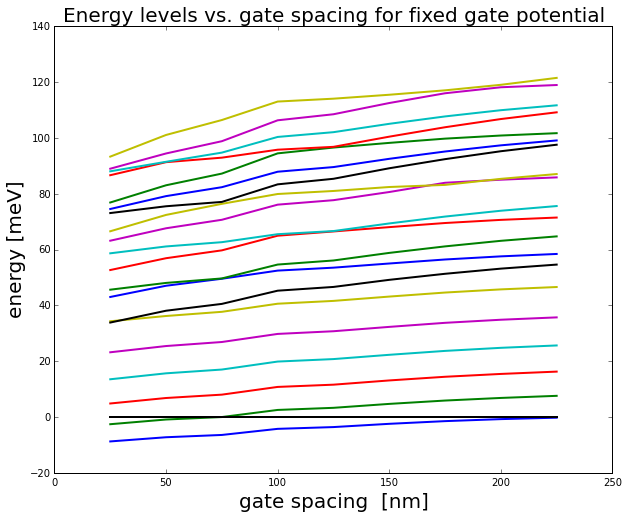

In [11]:
W_vacgap_range_scaled = 5*W_vacgap_range

fig = plt.figure(figsize=(10,8))
plt.hold(True)
for i in range(len(energy_matrix_gs[0, :])):
    plt.plot(W_vacgap_range_scaled, energy_matrix_gs[:, i], lw=2)
plt.plot(W_vacgap_range_scaled, np.zeros(len(W_vacgap_range_scaled)), 'k', lw=2)
plt.ylabel("energy [meV]", fontsize=20)
plt.xlabel("gate spacing  [nm]", fontsize=20)
plt.title("Energy levels vs. gate spacing for fixed gate potential", fontsize=20)
plt.show()

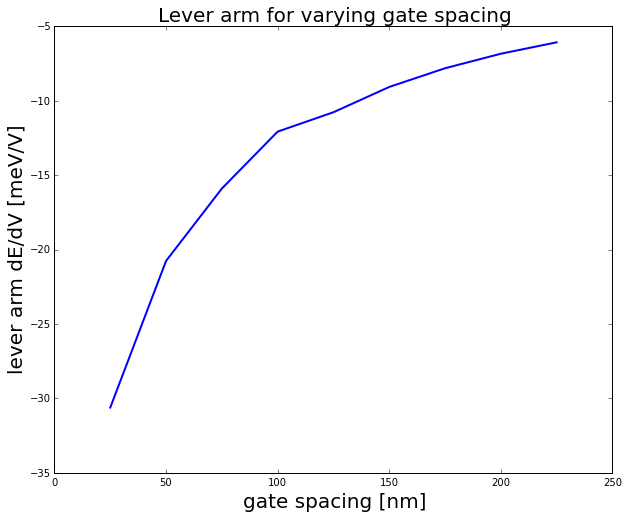

In [12]:
fig = plt.figure(figsize=(10,8))
plt.plot(W_vacgap_range_scaled, lever_arms_gap, lw=2)
plt.xlabel('gate spacing [nm]', fontsize=20)
plt.ylabel('lever arm dE/dV [meV/V]', fontsize=20)
plt.title('Lever arm for varying gate spacing', fontsize=20)
plt.show()

In [63]:
with open("data_marcus_device.p", 'wb') as fp:
    pickle.dump(W_vacgap_range_scaled, fp)
    pickle.dump(energy_matrix_gs, fp)
    pickle.dump(lever_arms_gap, fp)